In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as ss
from tqdm.notebook import tqdm
from glob import glob
from matplotlib import pyplot as plt

import Regressions as reg
import DataBuild as db

In [2]:
# get behavioral data for ltpFR2 all subjects
path = '/data/eeg/scalp/ltp/ltpFR2/behavioral/data/'
files = [f for f in glob(path+'beh_data_LTP*.json') if 'incomplete' not in f]

In [3]:
if 0:
    max_lag = 4
    lags = range(1,max_lag+1)
    aics = []
    bics = []
    r2s = []
    for file in tqdm(files):
        subj = file.split('LTP')[1].replace('.json', '')
        models = [reg.get_model(file, irt_lags=lag, min_irt=max_lag+1) for lag in lags]
        aics.append(pd.Series([m.aic for m in models], index=lags, name=subj))
        bics.append(pd.Series([m.bic for m in models], index=lags, name=subj))

        r2s.append(pd.Series([m.rsquared for m in models], index=lags, name=subj))
    aics = pd.concat(aics, axis=1).transpose()
    bics = pd.concat(bics, axis=1).transpose()
    r2s = pd.concat(r2s, axis=1).transpose()

In [4]:
if 0:
    stat = r2s
    stat_name = 'r^2'

    plt.errorbar(stat.columns, stat.mean(axis=0), yerr=stat.sem(axis=1).mean(axis=0),
                 marker='o', color='k', label=stat_name
                )
    plt.xlabel('Number of Lags')
    plt.ylabel(f'Avg {stat_name} Across Subjects')
    plt.xticks(range(1, max_lag+1))

In [5]:
# cross-validation (hold out subjects for testing -> 5/4)
# MSE-test error for test set
# add param for subject

In [6]:
def data_mult_subj(files, irt_lag, min_irt):
    
    filename = f'alldata_il{irt_lag}mi{min_irt}.pkl'
    if os.path.exists(filename):
        return pd.read_pickle(filename)
    
    all_data = []
    for file in tqdm(files):
        subj = file.split('LTP')[1].replace('.json', '')
        data = db.load_detailed_data(path=file, irt_lags=irt_lag, min_irt=min_irt)
        flat_data = reg.prep_data_for_ols(data)
        flat_data['subject'] = int(subj)
        all_data.append(flat_data)

    all_data = pd.concat(all_data)
    all_data.index = range(len(all_data))
    
    all_data.to_pickle(filename)
    
    return all_data

In [7]:
if 0:
    max_lag = 4
    lags = range(1,max_lag+1)
    mses = [[] for i in lags]
    mse_err = [[] for i in lags]

    # split into training and testing 5/4
    training_files = np.random.choice(files, 4*int(len(files)/5))
    testing_files = [f for f in files if not f in training_files]

    set_size = int(len(files)/5)


    for i, lag in enumerate(lags):

        data = data_mult_subj(files, irt_lag=lag, min_irt=max_lag+1)
        data.pop('total_recalls')
        data.pop('lag')
        data.pop('sem')
        data.pop('lag_sem')
        data.pop('output_pos')
        data.pop('session')

        for s in range(5):

            train_data = data[data['subject']%5!=s]
            test_data = data[data['subject']%5==s]

            # get model from training set
            model = reg.fit_model(train_data)

            # get mse
            y = test_data.pop('irt').values
            x = sm.add_constant(test_data)
            sq_error = (y - model.predict(x).values) ** 2
            mse = np.mean(sq_error)
            mses[i].append(mse)
            
    model = reg.fit_model(train_data)
    np.sum(model.resid**2)/len(model.resid)

In [8]:
import sklearn.model_selection

In [9]:
import sklearn.linear_model

In [10]:
from sklearn.model_selection import  GroupKFold

In [11]:
max_lag = 4
lags = range(1,max_lag+1)

In [12]:
def get_cv_scores(data, cv=5):
    
    X = data.copy()
    X['cnst'] = 1 # makes this a constant
    y = X.pop('irt')
    
    return sklearn.model_selection.cross_validate(
                    sklearn.linear_model.LinearRegression(),
                    cv=GroupKFold(cv), X=X, y=y, scoring='r2', groups = X['subject'],
        
                )['test_score']
    
    scores = []
    
    for subject in data['subject'].unique():
        
        s_data = data.query(f'subject=={subject}')

        X = s_data.copy()
        X['subject'] /= X['subject'] # makes this a constant
        y = X.pop('irt')

        scores.append(
            np.mean(
                sklearn.model_selection.cross_validate(
                    sklearn.linear_model.LinearRegression(),
                    cv=cv, X=X, y=y, scoring='r2'
                )['test_score']
            )
        )
#         fit = sklearn.linear_model.LinearRegression().fit(X, y)
#         scores.append(fit.score(X, y))
        
    return scores

In [13]:
lags = [0, *lags]

In [14]:
r2s = []
r2_errs = []
for i, lag in enumerate([0, *lags]):
    
    data = data_mult_subj(files, irt_lag=lag, min_irt=max_lag+1)
    r2s.append(get_cv_scores(data))
    r2_errs.append(ss.sem(scores))

NameError: name 'scores' is not defined

ValueError: 'x' and 'y' must have the same size

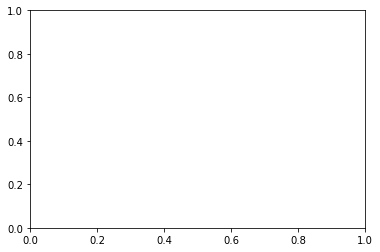

In [16]:
plt.errorbar(lags, [np.mean(x) for x in r2s], 
            # yerr=r2_errs,
             marker='o')
plt.xticks(lags)
plt.xlabel('Number of Lags')
plt.ylabel(r'Average $R^2$ of Folds');
plt.savefig('Cross_Validation.pdf')

In [17]:
cv_res = {}
data = data_mult_subj(files, irt_lag=1, min_irt=2)

for key in ['output_pos', 'session', 'lag', 'irt-1',
            'sem', 'total_recalls', 'lag_sem', None]:

    X = data.copy()
    if key is not None:
        X.pop(key)

    cv_res[key] = get_cv_scores(X, 5)

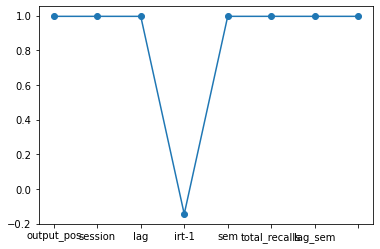

In [18]:
scores= [np.mean(cv_res[key]) for key in cv_res]
plt.plot(scores, marker='o')
plt.xticks(range(len(scores)), list(cv_res.keys()));

In [19]:
ss.ttest_ind(cv_res['session'], cv_res[None])

Ttest_indResult(statistic=-5.177627257663276e-05, pvalue=0.9999599563321913)

In [204]:
cv_res

{'output_pos': array([0.99713784, 0.99601237, 0.99546898, 0.99511334, 0.99420746]),
 'session': array([0.99713853, 0.99601288, 0.99546838, 0.99511296, 0.99420747]),
 'lag': array([0.99711617, 0.99596151, 0.99531536, 0.99500231, 0.99412409]),
 'sem': array([0.99713402, 0.99599999, 0.99544836, 0.99509454, 0.99419458]),
 'total_recalls': array([0.99713849, 0.99601339, 0.99546898, 0.99511317, 0.99420742]),
 'lag_sem': array([0.99713267, 0.99601044, 0.99546129, 0.9951094 , 0.99420332]),
 None: array([0.99713791, 0.99601242, 0.99546878, 0.99511324, 0.99420746])}

In [220]:
data = data_mult_subj(files, irt_lag=1, min_irt=2)